# 0. Libraries and setup

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords  # Stopwords list
from pandarallel import pandarallel  # For parallelizing pandas row operations
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from hw1_library import text_preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Loading the data

In [2]:
# Load the clean and merged data of protests
df = pd.read_csv('clean_data/ccc_combined.csv', low_memory=False)

df.head()

,date,year,month,state,type,issues,actors,claims,valence,size_low,size_high,size_mean,arrests_any,injuries_crowd_any,injuries_police_any,property_damage_any,notes
0,2017-01-01,2017,1.0,DC,vigil,military,NaN,for banning nuclear weapons; for peace,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,White House Peace Vigil continuous since June ...
1,2017-01-01,2017,1.0,MN,vigil,military,Peace Vigil Mankato,for peace,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,every Sunday since 2001
2,2017-01-01,2017,1.0,MN,protest; banner drop,banking and finance; economy; energy; environm...,general protestors,against the Dakota Access Pipeline; for indige...,1.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,hung banner from stadium roof during NFL game
3,2017-01-01,2017,1.0,RI,vigil,environment; guns; military,Sakonnet Peace Alliance,for peace; for gun control; for climate action,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,every Sunday since 2003
4,2017-01-01,2017,1.0,TN,vigil,military,Oak Ridge Environmental Peace Alliance,for abolishing nuclear weapons,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,every Sunday since the late 1990s


Explanation of the columns:

- `date`: Date of event in YYYY-MM-DD format. When an event spans multiple days, the start date is used.
- `state`: Two-letter U.S. postal abbreviation for the state or U.S. territory in which the event took place. 
- `type`: Type(s) of protest action (e.g. march, protest, demonstration, strike, counter-protest, sit-in), separated with semicolons when more than one.
- `issues`: String of semicolon-separated tags identifying political issues (or themes) associated with the event (e.g., "democracy; women's rights" for events associated with the 2017 Women's March).
- `actors`: The organization(s) that organized the protest event (e.g. Women's March, Greenpeace, etc.), and/or the type of people participating (e.g., students, nurses). Separated by semicolons.
- `claims`: A phrase or phrases describing what the event was about, based on the claims or demands the participants made (e.g. for women's rights, anti-Muslim Ban, against racism, etc.), as summarized by coders. Phrases are separated by semicolons. In the 2nd and 3rd editions of the data collection (from January 2021 to May 2025), this field also includes the title of the protest (if existent), concatenated and with semicolons as separators.
- `valence`: Political valence of the event.
  - 2 = pro-Trump
  - 1 = anti-Trump
  - 0 = other/neither
- `size_low`: Lowest crowd size reported in, or estimated from, `size_text`. To convert vague text counts to numbers, the following three rules are always used for both `size_low` and `size_high` (see below).
  1. For phrases with fudge words (e.g., “about”, “nealy” “approximately”, “maybe”), ignore the fudge word and treat the number that follows it as the count.
  2. When unspecific multiples are given, assume the multiple is 2  (e.g., “hundreds” becomes 200, “thousands” becomes 2,000).
  3. Assume “several” means 3 (e.g., “several dozen” becomes 36, “several thousand” becomes 3,000).
- `size_high`: Highest crowd size reported in, or estimated from, `size_text`. 
  - When vague text counts are converted to numbers, the high and low estimates are assumed to be equivalent. For example, if the only information available about crowd size is a single report describing it as “hundreds”, 200 would be assigned to both `size_low` and `size_high`. 
  - If, however, one source described the crowd size as “hundreds” and another as “about 500”, then size_low would still be 200, but size_high would be 500.
- `size_mean`: The mathematical average of `size_low` and `size_high`, rounded up to the nearest integer.
- `arrests_any`: Binary indicator for whether or not any arrests occurred, derived from arrests. 1 = yes, 0 = no.
- `injuries_crowd_any`: Binary indicator for whether or not any protesters were reportedly injured, derived from injuries_crowd. 1 = yes, 0 = no.
- `injuries_police_any`: Binary indicator for whether or not any police officers were reportedly injured, derived from injuries_police. 1 = yes, 0 = no.
- `property_damage_any`: Binary indicator for whether or not protesters reportedly caused any property damage, derived from property_damage. 1 = yes, 0 = no.
- `notes`: Miscellaneous additional information about the event as noted by the coder. 

# 2. Filtering protests by issue

In [3]:
# Unique issues
unique_issues = df['issues'].unique()

issues_set = set()  # Initialize an empty set to store unique issues

# Store unique issues in the set, ignoring NaN values and separating by semicolons
for issue in unique_issues:
    if pd.notna(issue):  # Check if the issue is not NaN
        issues = issue.split(';')  # Split the issues by semicolon
        for i in issues:
            issues_set.add(i.strip())  # Add each issue to the set, stripping whitespace

print(issues_set)

{'banking and finance', 'covid', 'racism', 'judiciary', 'corruption', '22.0', 'guns', 'development', 'free speech', 'economy', 'foreign affairs', 'sports', 'lgbtqia', 'environment', 'taxes', 'drugs', 'democracy', "women's rights", 'policing', 'war and peace', 'animal rights', 'legislative', 'military', 'transportation', 'immigration', '25.0', 'reproductive rights', 'religion', 'labor and workers rights', 'patriotism', 'healthcare', 'sexual violence', 'disability rights', 'presidency', 'labor', 'criminal justice', 'education', 'energy', 'indigenous peoples', 'civil rights', 'local development', 'science', 'housing'}


Topics to be considered:
- healthcare
- racism + immigration
- housing
- guns + criminal justice

In [4]:
topics = ['healthcare', 'racism', 'immigration', 'housing', 'guns', 'criminal justice']

Let's check out the distribution of issues per state.

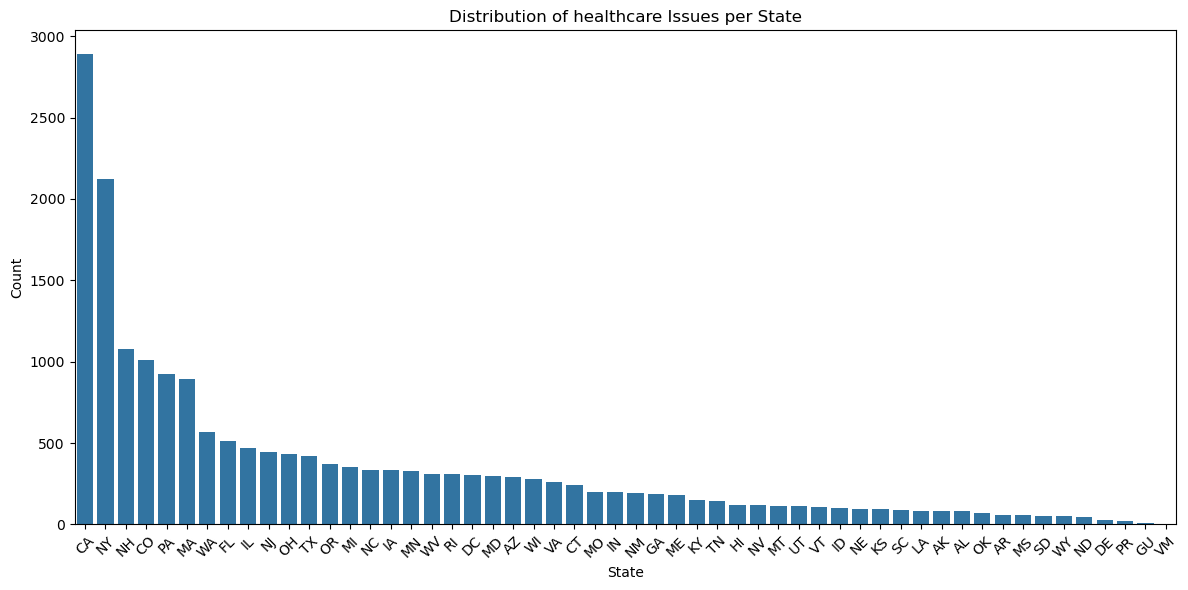

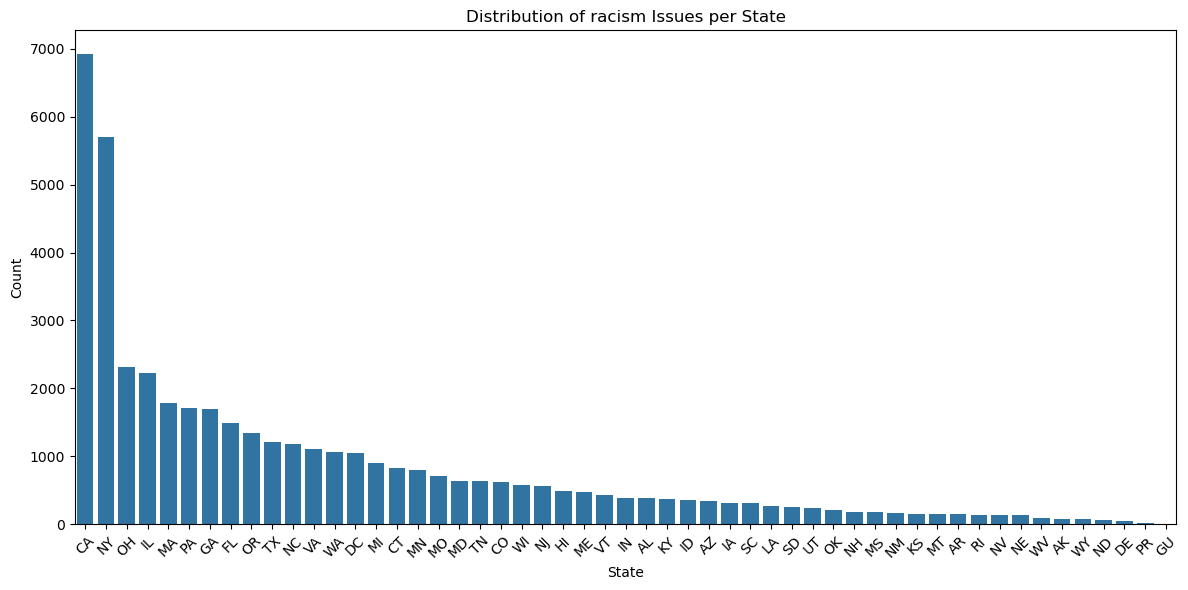

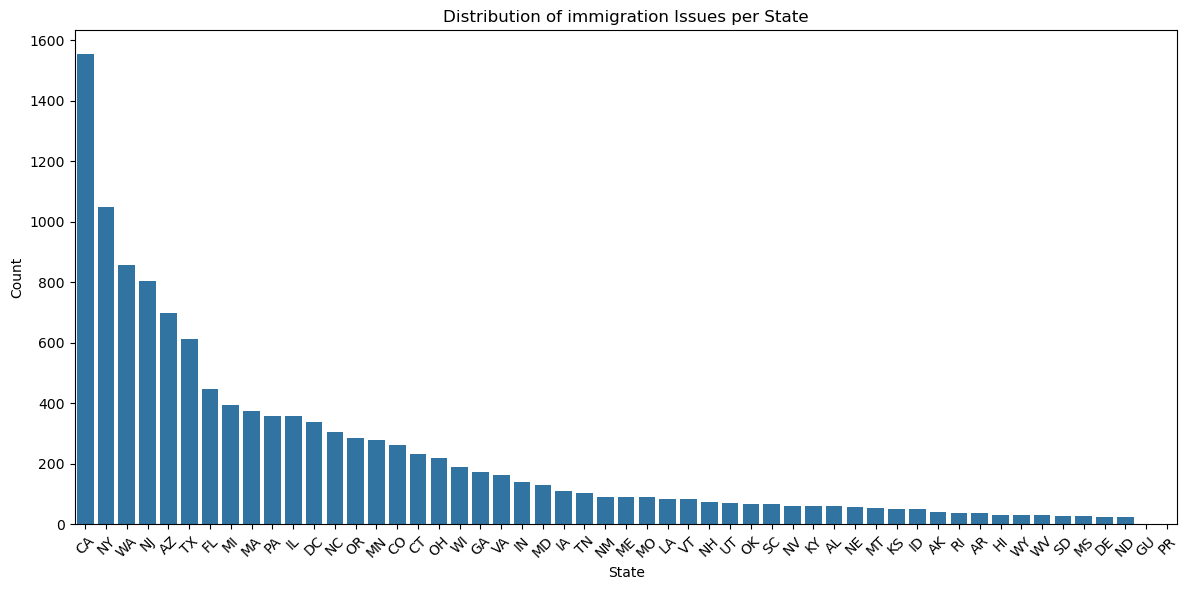

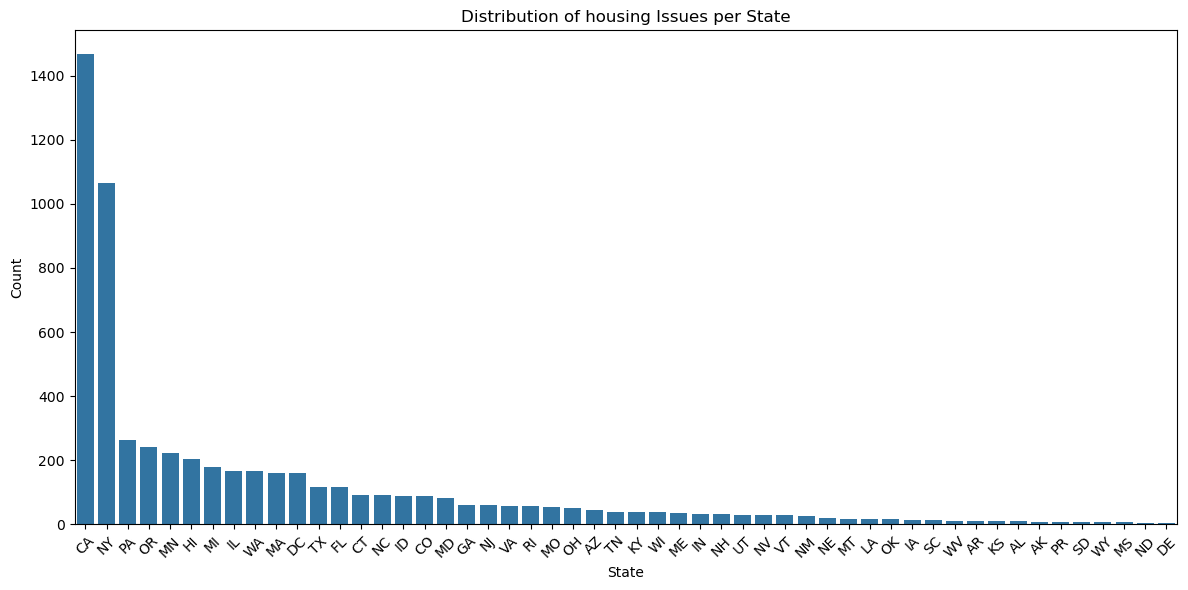

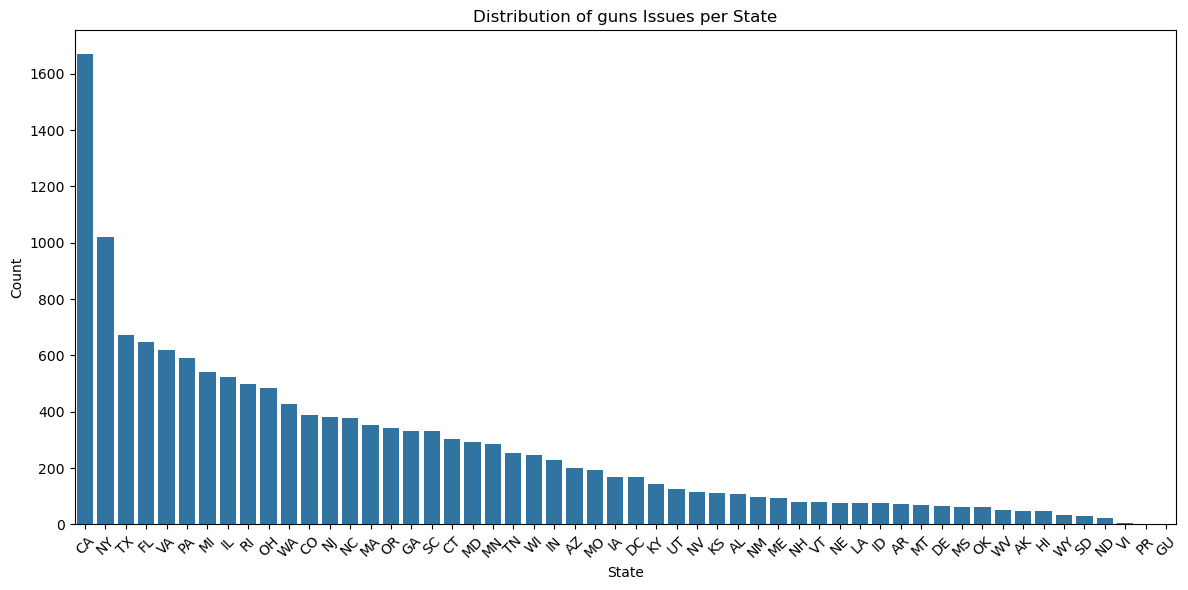

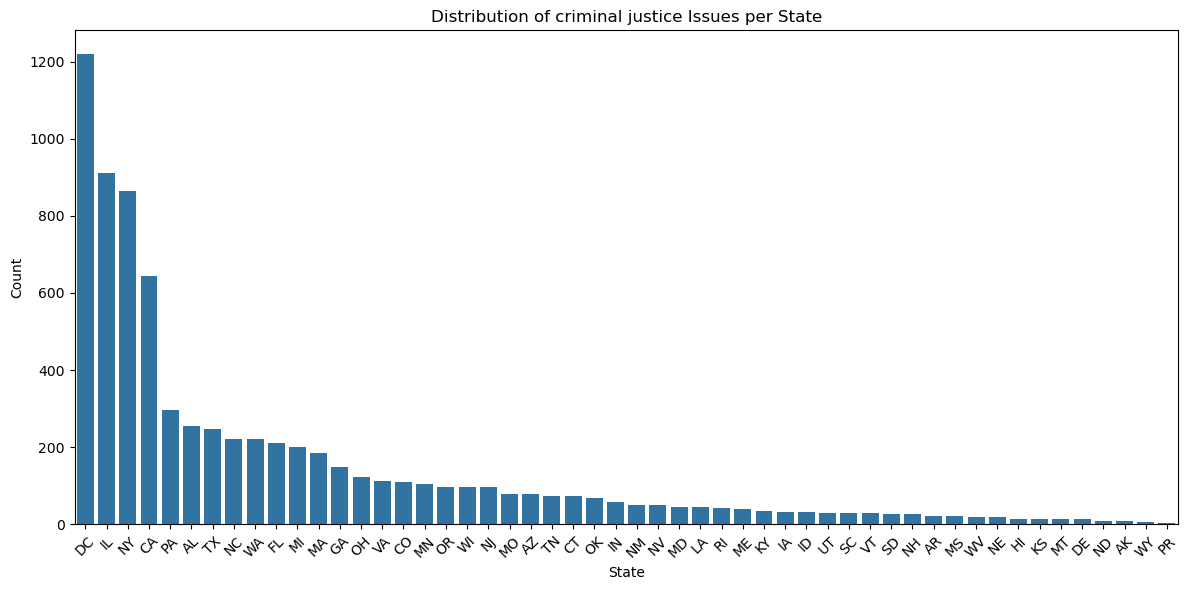

In [5]:
for topic in topics:

    # Check distribution of each per state
    filtered_df = df[df['issues'].str.contains(topic, na=False)]
    plt.figure(figsize=(12, 6))
    sns.countplot(data=filtered_df, x='state', order=filtered_df['state'].value_counts().index)
    plt.title(f'Distribution of {topic} Issues per State')
    plt.xticks(rotation=45)
    plt.xlabel('State')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

del filtered_df

Except for the guns issues, we can observe that the protests are generally concentrated on 2-4 states. However, the states with the highest count of protests also match (in general), as expected, the states with the largest population (California, New York, Illinois, etc.). 

In [6]:
# Keep only the rows containing any of the issues of interest
df_filtered = df[df['issues'].str.contains('|'.join(topics), na=False)].reset_index(drop=True)

df_filtered.head()

,date,year,month,state,type,issues,actors,claims,valence,size_low,size_high,size_mean,arrests_any,injuries_crowd_any,injuries_police_any,property_damage_any,notes
0,2017-01-01,2017,1.0,RI,vigil,environment; guns; military,Sakonnet Peace Alliance,for peace; for gun control; for climate action,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,every Sunday since 2003
1,2017-01-04,2017,1.0,MI,protest,education; racism,EMU's NAACP Chapter; EMU students,against racial incidents on campus; for pressu...,1.0,100.0,300.0,200.0,0.0,0.0,0.0,0.0,NaN
2,2017-01-07,2017,1.0,IL,protest,racism,general protestors,against racism; against racial incident at Dai...,1.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,NaN
3,2017-01-08,2017,1.0,RI,vigil,environment; guns; military,Sakonnet Peace Alliance,for peace; for gun control; for climate action,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,every Sunday since 2003
4,2017-01-11,2017,1.0,NY,vigil,guns,family and friends of Shamoya Mckenzie,against gun violence in Westchester community,1.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,NaN


In [7]:
# Print proportion of protests for each issue
for topic in topics:
    total_protests = len(df_filtered)
    number_of_protests_topic = len(df_filtered[df_filtered['issues'].str.contains(topic)])
    proportion = number_of_protests_topic / total_protests
    print(f"Proportion of protests for {topic}: {proportion:.2%} (number of protests: {number_of_protests_topic})")

Proportion of protests for healthcare: 20.43% (number of protests: 18633)
Proportion of protests for racism: 47.92% (number of protests: 43712)
Proportion of protests for immigration: 13.01% (number of protests: 11870)
Proportion of protests for housing: 6.43% (number of protests: 5864)
Proportion of protests for guns: 15.70% (number of protests: 14320)
Proportion of protests for criminal justice: 8.19% (number of protests: 7473)


# 3. Text preprocessing: claims

In this section we preprocess the text data contained in the column `claims`. The columns `issues` and `actors` are not preprocessed as, in the first case, the data is already "normalized", while in the second case preprocessing would risk losing valuable data.

In [8]:
# Initialize parallelization for pandas
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 3.1. Tokenizing and stopword removal

In [9]:
my_stop_words = set(stopwords.words('english'))

# Create set of custom stopwords (optional)
my_custom_stopwords = {}

# Update stopwords (optional)
my_stop_words.update(my_custom_stopwords)

In [10]:
# Note that, with the preprocessing, we will remove the stopwords and punctuation
# (the semicolons) from the text
df_filtered['claims_lower_nostop'] = df_filtered['claims'].parallel_apply(
    lambda row: text_preprocessing.lower_nostop(text = row, rm_stopwords=True, stopword_set=my_stop_words) if pd.notna(row) else row
    )

In [11]:
df_filtered.head()

,date,year,month,state,type,issues,actors,claims,valence,size_low,size_high,size_mean,arrests_any,injuries_crowd_any,injuries_police_any,property_damage_any,notes,claims_lower_nostop
0,2017-01-01,2017,1.0,RI,vigil,environment; guns; military,Sakonnet Peace Alliance,for peace; for gun control; for climate action,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,every Sunday since 2003,peace gun control climate action
1,2017-01-04,2017,1.0,MI,protest,education; racism,EMU's NAACP Chapter; EMU students,against racial incidents on campus; for pressu...,1.0,100.0,300.0,200.0,0.0,0.0,0.0,0.0,NaN,racial incidents campus pressuring university ...
2,2017-01-07,2017,1.0,IL,protest,racism,general protestors,against racism; against racial incident at Dai...,1.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,NaN,racism racial incident dairy queen restaurant
3,2017-01-08,2017,1.0,RI,vigil,environment; guns; military,Sakonnet Peace Alliance,for peace; for gun control; for climate action,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,every Sunday since 2003,peace gun control climate action
4,2017-01-11,2017,1.0,NY,vigil,guns,family and friends of Shamoya Mckenzie,against gun violence in Westchester community,1.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,NaN,gun violence westchester community


Note that Google Trends is not, apparently, case-sensitive. Therefore, the index shown for "ice" is the same as for "ICE", so lowering all of the text will not have an effect in the Google Trends searches.

## 3.2. Normalizing: lemmatization

In [12]:
df_filtered['claims_lemmatized'] = df_filtered['claims_lower_nostop'].parallel_apply(
    lambda row: text_preprocessing.lemmatize(text = row) if pd.notna(row) else row
    )

In [13]:
df_filtered.head()

,date,year,month,state,type,issues,actors,claims,valence,size_low,size_high,size_mean,arrests_any,injuries_crowd_any,injuries_police_any,property_damage_any,notes,claims_lower_nostop,claims_lemmatized
0,2017-01-01,2017,1.0,RI,vigil,environment; guns; military,Sakonnet Peace Alliance,for peace; for gun control; for climate action,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,every Sunday since 2003,peace gun control climate action,peace gun control climate action
1,2017-01-04,2017,1.0,MI,protest,education; racism,EMU's NAACP Chapter; EMU students,against racial incidents on campus; for pressu...,1.0,100.0,300.0,200.0,0.0,0.0,0.0,0.0,NaN,racial incidents campus pressuring university ...,racial incident campus pressuring university a...
2,2017-01-07,2017,1.0,IL,protest,racism,general protestors,against racism; against racial incident at Dai...,1.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,NaN,racism racial incident dairy queen restaurant,racism racial incident dairy queen restaurant
3,2017-01-08,2017,1.0,RI,vigil,environment; guns; military,Sakonnet Peace Alliance,for peace; for gun control; for climate action,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,every Sunday since 2003,peace gun control climate action,peace gun control climate action
4,2017-01-11,2017,1.0,NY,vigil,guns,family and friends of Shamoya Mckenzie,against gun violence in Westchester community,1.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,NaN,gun violence westchester community,gun violence westchester community


In [14]:
# Print sample text
claim_index = 20
print('Original claim: \n', df_filtered['claims'].iloc[claim_index], '\n')
print('Lowercased claim with no stopwords and no punctuation: \n', df_filtered['claims_lower_nostop'].iloc[claim_index], '\n')
print('Lemmatized claim: \n', df_filtered['claims_lemmatized'].iloc[claim_index])

Original claim: 
 for forming a union; for addressing chronic nursing staffing shortages 

Lowercased claim with no stopwords and no punctuation: 
 forming union addressing chronic nursing staffing shortages 

Lemmatized claim: 
 forming union addressing chronic nursing staffing shortage


The changes in the lemmatized claims are very subtle, and sometimes it risks losing valuable information (like catchy protest slogans). Therefore, and since the vocabulary and the strings are not very large, in the application below we use the preprocessed claim text that has not been lemmatized.

## 3.3. Vectorizing

For vectorizing, the first step that we have to follow is to do it only for the non-null values. After that, we want to vectorize separately for each of the different topics, in order to form a different text corpus for each issue. The idea behind this is to avoid dilluting information of protests that are more common in the US (e.g., racism-related protests) in the TF-IDF pipeline. Topics to be considered:
- healthcare
- racism + immigration
- housing
- guns + criminal justice 

### Dividing the corpus by topic and removing null values

In [15]:
# Remove rows with NaN values in 'claims_lower_nostop'
df_filtered_nona = df_filtered.dropna(subset=['claims_lower_nostop'])

In [27]:
# Create one data frame per topic
topics = ['healthcare', ['racism', 'immigration'], 'housing', ['guns', 'criminal justice']]

# Initialize an empty dictionary to store DataFrames
df_dict = {}

for topic in topics:

    # Create a dynamic variable name and data frame for each topic - if the topic 
    # is a list, consider only the first element of the list to create the variable 
    # name
    if isinstance(topic, list):
        topic_name = topic[0]
        df = df_filtered_nona[df_filtered_nona['issues'].str.contains('|'.join(topic), na=False)]
    elif isinstance(topic, str):
        topic_name = topic
        df = df_filtered_nona[df_filtered_nona['issues'].str.contains(topic, na=False)]
    else:
        raise ValueError("Topic must be a string or a non-empty list of strings.")

    # Store the DataFrame in the dictionary
    df_dict[topic_name] = df

In [28]:
print(df_dict.keys())

dict_keys(['healthcare', 'racism', 'housing', 'guns'])


In [29]:
# Print an example of the data frame for the topic 'healthcare'
df_dict['healthcare'].head()

,date,year,month,state,type,issues,actors,claims,valence,size_low,size_high,size_mean,arrests_any,injuries_crowd_any,injuries_police_any,property_damage_any,notes,claims_lower_nostop,claims_lemmatized
8,2017-01-15,2017,1.0,MA,protest,healthcare,general protestors,against Republican effort to repeal the ACA; h...,1.0,2000.0,2000.0,2000.0,0.0,0.0,0.0,0.0,NaN,republican effort repeal aca health care,republican effort repeal aca health care
9,2017-01-15,2017,1.0,NY,protest,healthcare,general protestors,against Republican effort to repeal the ACA; h...,1.0,100.0,200.0,150.0,0.0,0.0,0.0,0.0,NaN,republican effort repeal aca health care,republican effort repeal aca health care
11,2017-01-15,2017,1.0,VA,protest,healthcare,general protestors,against Republican effort to repeal the ACA; h...,1.0,200.0,300.0,250.0,0.0,0.0,0.0,0.0,NaN,republican effort repeal aca health care,republican effort repeal aca health care
13,2017-01-16,2017,1.0,NC,rally,healthcare,general protestors,for health care and ACA; save our healthcare r...,1.0,150.0,150.0,150.0,0.0,0.0,0.0,0.0,NaN,health care aca save healthcare rally,health care aca save healthcare rally
14,2017-01-16,2017,1.0,NY,protest,healthcare,health care advocates; Rise and Resist,against Republican effort to repeal the ACA; h...,1.0,15.0,15.0,15.0,0.0,0.0,0.0,0.0,NaN,republican effort repeal aca health care,republican effort repeal aca health care


In [32]:
df_dict['racism'].head()

,date,year,month,state,type,issues,actors,claims,valence,size_low,size_high,size_mean,arrests_any,injuries_crowd_any,injuries_police_any,property_damage_any,notes,claims_lower_nostop,claims_lemmatized
1,2017-01-04,2017,1.0,MI,protest,education; racism,EMU's NAACP Chapter; EMU students,against racial incidents on campus; for pressu...,1.0,100.0,300.0,200.0,0.0,0.0,0.0,0.0,NaN,racial incidents campus pressuring university ...,racial incident campus pressuring university a...
2,2017-01-07,2017,1.0,IL,protest,racism,general protestors,against racism; against racial incident at Dai...,1.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,NaN,racism racial incident dairy queen restaurant,racism racial incident dairy queen restaurant
5,2017-01-12,2017,1.0,OR,vigil,policing; racism,NaN,for justice for Keaton Otis; against police br...,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Justice for Keaton Otis 12th of every month si...,justice keaton otis police brutality police ac...,justice keaton otis police brutality police ac...
6,2017-01-14,2017,1.0,MA,rally,education; immigration; labor,students and dining hall employees,for university protections for undocumented wo...,1.0,50.0,60.0,55.0,0.0,0.0,0.0,0.0,NaN,university protections undocumented workers,university protection undocumented worker
12,2017-01-16,2017,1.0,MT,demonstration,racism,Industrial Workers of the World - Missoula; Qu...,against white supremacy; against neo-Nazis; fo...,1.0,50.0,50.0,50.0,0.0,0.0,0.0,0.0,counter-protest to a neo-Nazi protest that was...,white supremacy neo nazis solidarity whitefish...,white supremacy neo nazi solidarity whitefish ...


In [33]:
# Print the shape of all data frames per topic
for topic in df_dict.keys():
    print(f"Shape of DataFrame for {topic}: {df_dict[topic].shape}")

Shape of DataFrame for healthcare: (18618, 19)
Shape of DataFrame for racism: (53655, 19)
Shape of DataFrame for housing: (5856, 19)
Shape of DataFrame for guns: (21720, 19)


### Applying TF-IDF

In [56]:
# Step 1: initialize the tfidf vectorizer
tfidf = TfidfVectorizer(
    lowercase=False,
    stop_words=None,
    sublinear_tf=True, 
    smooth_idf=False, 
    ngram_range=(1,3),  # Include unigrams, bigrams, trigrams
    min_df=0.02,  # Ignore terms appearing in less than x% of the documents
    max_df=1.0,  # Ignore terms appearing in more than x% of the documents 
    )

# Step 2: For each data frame in the dictionary, we will create a DTM and a list of 
# terms and store them in a dictionary

dtm_dict = {}  # Initialize an empty dictionary to store DTMs
terms_dict = {}  # Initialize an empty dictionary to store terms

for topic_name, df in df_dict.items():

    # Print the name of the topic
    print(f'Processing topic: {topic_name}')

    # Create a DTM and a list of terms for each topic
    dtm, terms = text_preprocessing.vectorizer(
        cv = tfidf, df = df, column_text='claims_lower_nostop'
        )
    
    print('\n')

    # Store the DTM and terms in the dictionaries
    dtm_dict[topic_name] = dtm
    terms_dict[topic_name] = terms

Processing topic: healthcare
Document-term matrix has size (documents, terms) (18618, 345)


Processing topic: racism
Document-term matrix has size (documents, terms) (53655, 96)


Processing topic: housing
Document-term matrix has size (documents, terms) (5856, 197)


Processing topic: guns
Document-term matrix has size (documents, terms) (21720, 140)




In [57]:
terms_dict['healthcare']

array(['19', '19 vaccination', '19 vaccination mandate',
       '19 vaccination mandates', 'abortion', 'access', 'act', 'action',
       'actions', 'actions trump', 'actions trump administration',
       'administration', 'administration ending',
       'administration ending cuts', 'administration ending rampant',
       'administration plutocratic', 'administration plutocratic allies',
       'affordable', 'aid', 'aid social', 'aid social security', 'allies',
       'allies hostile', 'allies hostile government', 'allies stopping',
       'allies stopping chaos', 'anti', 'anti democratic',
       'anti democratic illegal', 'attacks', 'attacks health',
       'attacks health care', 'attacks immigrants',
       'attacks immigrants transgenders', 'back', 'benefit',
       'benefit trump', 'benefit trump billionaire', 'benefits',
       'benefits stationary', 'benefits stationary biomedical',
       'benefits united', 'benefits united metro', 'better',
       'better health', 'better heal

We can observe that there are terms that are quite circumstantial and of very particular issues, such as '19' (referencing COVID-19). These terms will not have a good predictive power over protests in the longer term. On the other hand, some terms are more general in the fight towards better healthcare, such as "better health benefits".

In [58]:
# Convert each DTM to a data frame with the terms as columns
dtm_df_dict = {}  # Initialize an empty dictionary to store DTM data frames
for topic_name, dtm in dtm_dict.items():
    # Convert the DTM to a DataFrame
    dtm_df = pd.DataFrame(dtm, columns=terms_dict[topic_name])
    
    # Store the DataFrame in the dictionary
    dtm_df_dict[topic_name] = dtm_df

In [59]:
# For example, print the DTM for the topic 'healthcare'
dtm_df_dict['healthcare'].head()

,19,19 vaccination,19 vaccination mandate,19 vaccination mandates,abortion,access,act,action,actions,actions trump,...,within trump administration,women,women rights,workers,workers king,workers king soopers,working,working class,working class depends,workplace
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# Print the shape of each of the DTM data frames
for topic_name, dtm_df in dtm_df_dict.items():
    print(f"Shape of DTM DataFrame for {topic_name}: {dtm_df.shape}")

Shape of DTM DataFrame for healthcare: (18618, 345)
Shape of DTM DataFrame for racism: (53655, 96)
Shape of DTM DataFrame for housing: (5856, 197)
Shape of DTM DataFrame for guns: (21720, 140)


# 4. Analysis

## 4.1. Adding relevant metadata to the DTMs

In this section, we add the date of each protest (the year and the month) to each of the documents in each DTM, to be able to distinguish when the n-gram was first stated. This is done in order to avoid data leakage in the validation and test sets: to avoid data leakage, we are not supposed to know the claims that are made at a specific time in the future.

In [61]:
# For each DTM, add a column with the date of the protest
for topic_name, df in df_dict.items():
    dtm_df = dtm_df_dict[topic_name]
    dtm_df['date'] = df['date'].reset_index(drop=True)  # Add the date column
    dtm_df['date'] = pd.to_datetime(dtm_df['date']).dt.to_period('M').astype(str)  # Convert date to string format YYYY-MM (keep only year and month)
    dtm_df['claims'] = df['claims'].reset_index(drop=True)  # Add the claims column as a reference to check if everything is ok
    dtm_df_dict[topic_name] = dtm_df

In [62]:
sample = dtm_df_dict['healthcare']

sample.head()

,19,19 vaccination,19 vaccination mandate,19 vaccination mandates,abortion,access,act,action,actions,actions trump,...,women rights,workers,workers king,workers king soopers,working,working class,working class depends,workplace,date,claims
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-01,against Republican effort to repeal the ACA; h...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-01,against Republican effort to repeal the ACA; h...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-01,against Republican effort to repeal the ACA; h...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-01,for health care and ACA; save our healthcare r...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-01,against Republican effort to repeal the ACA; h...


After doing a simple inspection of the TF-IDF weights some rows, the claims seem to match with the TF-IDF weights (and, thus, the dates match as well).

## 4.2. Ranking top terms per topic

In this step, we:
1. Aggregate the TF-IDF weights across rows for each topic, in order to get a ranking of the top keywords per topic.
2. For each keyword, create a list of the dates (year and month) when that keyword was claimed, in order to keep track of the features that would imply data leakage.

In [63]:
# Calculate term frequencies (total counts across all documents)
term_frequencies = dtm_dict['healthcare'].sum(axis=0).A1  # Convert to 1D array

# Create a DataFrame for easier handling
df_terms_description = pd.DataFrame({
    'term': terms_dict['healthcare'],
    'tfidf_weight': term_frequencies
})

# Sort the DataFrame by frequency in descending order
df_terms_description = df_terms_description.sort_values(by='tfidf_weight', ascending=False).reset_index(drop=True)

# Assign an ID from 1 (most frequent) to V (least frequent)
df_terms_description['id'] = df_terms_description.index + 1

df_terms_description.head()

,term,tfidf_weight,id
0,health,1087.105060,1
1,freedom,1029.110391,2
2,healthcare,798.293371,3
3,workers,776.630801,4
4,covid,731.346596,5


### Aggregating TF-IDF weights per topic

In [65]:
# Create a dictionary to store the ranked terms for each topic
topic_keywords = {}

# Process each topic
for topic_name, dtm_df in dtm_df_dict.items():
    # Get columns that are terms (exclude 'date' and 'claims')
    term_columns = [col for col in dtm_df.columns if col not in ['date', 'claims']]
    
    # Calculate total TF-IDF weights across all documents
    term_frequencies = dtm_df[term_columns].sum(axis=0)
    
    # Create a DataFrame for easier handling
    df_terms = pd.DataFrame({
        'term': term_columns,
        'tfidf_weight_sum': term_frequencies.values
    })
    
    # Sort by TF-IDF weight in descending order
    df_terms = df_terms.sort_values(by='tfidf_weight_sum', ascending=False).reset_index(drop=True)
    
    # Add rank
    df_terms['rank'] = df_terms.index + 1
    
    # Store in the dictionary
    topic_keywords[topic_name] = df_terms
    
    # Display top 10 terms for this topic
    print(f"\nTop 10 keywords for {topic_name}:")
    print(df_terms.head(10))


Top 10 keywords for healthcare:
          term  tfidf_weight_sum  rank
0       health       1087.105060     1
1      freedom       1029.110391     2
2   healthcare        798.293371     3
3      workers        776.630801     4
4        covid        731.346596     5
5     mandates        730.610227     6
6       higher        726.324514     7
7      medical        673.161199     8
8       rights        662.650638     9
9  vaccination        654.531317    10

Top 10 keywords for racism:
                          term  tfidf_weight_sum  rank
0                       police       6899.473343     1
1                       racism       5996.521226     2
2                    brutality       5286.727006     3
3             police brutality       5284.629812     4
4                   antiracism       3909.306557     5
5            antiracism police       3781.676301     6
6  antiracism police brutality       3771.871875     7
7                racism police       3220.110295     8
8             

### Keeping track of dates when keywords appeared

In [71]:
# Create a dictionary to store the dates for each keyword by topic
keyword_dates = {}

# Process each topic
for topic_name, dtm_df in dtm_df_dict.items():
    # Get columns that are terms
    term_columns = [col for col in dtm_df.columns if col not in ['date', 'claims']]
    
    # Initialize dictionary for this topic
    keyword_dates[topic_name] = {}
    
    # For each term, get all dates when it appeared
    for term in term_columns:
        # Get rows where the term has a non-zero TF-IDF weight
        term_occurrences = dtm_df.loc[dtm_df[term] > 0]
        
        # Store the dates and corresponding TF-IDF weights
        keyword_dates[topic_name][term] = {
            'dates': term_occurrences['date'].tolist(),
            'unique_dates': sorted(list(set(term_occurrences['date'].tolist()))),
            'weights': term_occurrences[term].tolist(),
            'first_appearance': term_occurrences['date'].min() if not term_occurrences.empty else None,
            'count': len(term_occurrences)
        }
    
    # Example: Display dates for top keyword
    top_term = topic_keywords[topic_name]['term'].iloc[0]
    print(f"\nDates for top keyword '{top_term}' in {topic_name}:")
    print(f"First appearance: {keyword_dates[topic_name][top_term]['first_appearance']}")
    print(f"Number of occurrences: {keyword_dates[topic_name][top_term]['count']}")
    print(f"Sample dates: {keyword_dates[topic_name][top_term]['dates'][:5]} ...")
    print(f"Sample unique dates: {keyword_dates[topic_name][top_term]['unique_dates'][:5]} ...")


Dates for top keyword 'health' in healthcare:
First appearance: 2017-01
Number of occurrences: 6324
Sample dates: ['2017-01', '2017-01', '2017-01', '2017-01', '2017-01'] ...
Sample unique dates: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05'] ...

Dates for top keyword 'police' in racism:
First appearance: 2017-01
Number of occurrences: 24296
Sample dates: ['2017-01', '2017-02', '2017-02', '2017-02', '2017-02'] ...
Sample unique dates: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05'] ...

Dates for top keyword 'housing' in housing:
First appearance: 2017-02
Number of occurrences: 2269
Sample dates: ['2017-02', '2017-02', '2017-03', '2017-04', '2017-04'] ...
Sample unique dates: ['2017-02', '2017-03', '2017-04', '2017-05', '2017-06'] ...

Dates for top keyword 'gun' in guns:
First appearance: 2017-01
Number of occurrences: 12966
Sample dates: ['2017-01', '2017-01', '2017-01', '2017-01', '2017-01'] ...
Sample unique dates: ['2017-01', '2017-02', '2017-03', '2017-04', '201

### Merging the ranking with the metadata

In [ ]:
# Create a dictionary to store the merged data for each topic
merged_keywords = {}

# Process each topic
for topic_name in topic_keywords.keys():
    # Get the ranked terms DataFrame
    ranked_terms = topic_keywords[topic_name]
    
    # Create lists to store the additional metadata
    first_appearances = []
    occurrence_counts = []
    unique_date_counts = []
    all_unique_dates = []
    
    # For each term, get its metadata from keyword_dates
    for term in ranked_terms['term']:
        term_data = keyword_dates[topic_name][term]
        first_appearances.append(term_data['first_appearance'])
        occurrence_counts.append(term_data['count'])
        unique_dates = term_data['unique_dates']
        unique_date_counts.append(len(unique_dates))
        all_unique_dates.append(unique_dates)
    
    # Add the metadata to the ranked terms DataFrame
    merged_df = ranked_terms.copy()
    merged_df['first_appearance'] = first_appearances
    merged_df['occurrence_count'] = occurrence_counts
    merged_df['unique_date_count'] = unique_date_counts
    merged_df['unique_dates'] = all_unique_dates
    
    # Store in the dictionary
    merged_keywords[topic_name] = merged_df
    
    # Display sample of merged data
    print(f"\nSample of merged data for {topic_name}:")
    print(merged_df.head(3))


Sample of merged data for healthcare:
         term  tfidf_weight_sum  rank first_appearance  occurrence_count  \
0      health       1087.105060     1          2017-01              6324   
1     freedom       1029.110391     2          2019-12              3187   
2  healthcare        798.293371     3          2017-01              2259   

   unique_date_count                                       unique_dates  
0                 95  [2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ...  
1                 60  [2019-12, 2020-01, 2020-02, 2020-07, 2020-09, ...  
2                 95  [2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ...  

Sample of merged data for racism:
        term  tfidf_weight_sum  rank first_appearance  occurrence_count  \
0     police       6899.473343     1          2017-01             24296   
1     racism       5996.521226     2          2017-01             18110   
2  brutality       5286.727006     3          2017-01             17539   

   unique_date_count    

In [89]:
healthcare_top_keywords = merged_keywords['healthcare']
racism_top_keywords = merged_keywords['racism']
housing_top_keywords = merged_keywords['housing']
guns_top_keywords = merged_keywords['guns']

Let's do a visual inspection of the top keywords to check whether there are some terms worth removing (such as anything COVID-related, which can only be predictive of protests for a very specific period).

In [90]:
healthcare_top_keywords.head()

,term,tfidf_weight_sum,rank,first_appearance,occurrence_count,unique_date_count,unique_dates
0,health,1087.105060,1,2017-01,6324,95,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
1,freedom,1029.110391,2,2019-12,3187,60,"[2019-12, 2020-01, 2020-02, 2020-07, 2020-09, ..."
2,healthcare,798.293371,3,2017-01,2259,95,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
3,workers,776.630801,4,2017-05,3910,68,"[2017-05, 2017-08, 2017-12, 2018-09, 2020-01, ..."
4,covid,731.346596,5,2020-03,2584,58,"[2020-03, 2020-04, 2020-05, 2020-06, 2020-07, ..."


In [85]:
racism_top_keywords.head()

,term,tfidf_weight_sum,rank,first_appearance,occurrence_count,unique_date_count,unique_dates
0,police,6899.473343,1,2017-01,24296,100,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
1,racism,5996.521226,2,2017-01,18110,100,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
2,brutality,5286.727006,3,2017-01,17539,100,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
3,police brutality,5284.629812,4,2017-01,17529,100,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
4,antiracism,3909.306557,5,2020-05,8413,7,"[2020-05, 2020-06, 2020-07, 2020-08, 2020-09, ..."


In [83]:
housing_top_keywords.head()

,term,tfidf_weight_sum,rank,first_appearance,occurrence_count,unique_date_count,unique_dates
0,housing,536.951855,1,2017-02,2269,95,"[2017-02, 2017-03, 2017-04, 2017-05, 2017-06, ..."
1,homeless,406.300073,2,2017-02,1566,92,"[2017-02, 2017-03, 2017-04, 2017-05, 2017-08, ..."
2,people,300.953726,3,2017-03,971,73,"[2017-03, 2017-04, 2017-08, 2017-11, 2017-12, ..."
3,rights,270.311923,4,2017-04,849,72,"[2017-04, 2017-05, 2017-09, 2017-11, 2017-12, ..."
4,homelessness,265.182908,5,2017-03,842,70,"[2017-03, 2017-07, 2017-08, 2017-09, 2017-12, ..."


In [84]:
guns_top_keywords.head()

,term,tfidf_weight_sum,rank,first_appearance,occurrence_count,unique_date_count,unique_dates
0,gun,3359.779389,1,2017-01,12966,100,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
1,violence,2179.795697,2,2017-01,8261,100,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
2,gun violence,2118.528642,3,2017-01,7988,100,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
3,control,1953.614693,4,2017-01,7362,100,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
4,gun control,1952.182062,5,2017-01,7343,100,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."


From all the considered topics, only the terms relative to COVID (like "covid", "19", "corona" or "mask") from the healthcare topic seem too specific and circumstantial and, thus, should be removed as their Google Trends index will probably not have a good predictive power over the long run.

The removal of terms related to the overturning of the Roe v. Wade ruling could also be considered, but in this case the effects could last for longer.

In [91]:
# Of the healthcare keywords, remove those containing "covid", "19" or "corona"
healthcare_top_keywords = healthcare_top_keywords[~healthcare_top_keywords['term'].str.contains('covid|19|corona|mask', case=False)].reset_index(drop=True)

healthcare_top_keywords.head()

,term,tfidf_weight_sum,rank,first_appearance,occurrence_count,unique_date_count,unique_dates
0,health,1087.105060,1,2017-01,6324,95,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
1,freedom,1029.110391,2,2019-12,3187,60,"[2019-12, 2020-01, 2020-02, 2020-07, 2020-09, ..."
2,healthcare,798.293371,3,2017-01,2259,95,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
3,workers,776.630801,4,2017-05,3910,68,"[2017-05, 2017-08, 2017-12, 2018-09, 2020-01, ..."
4,mandates,730.610227,6,2019-05,2839,59,"[2019-05, 2019-12, 2020-01, 2020-02, 2020-03, ..."


### Saving the results to .csv

In [99]:
healthcare_top_keywords.to_csv('clean_data/top_claims/healthcare_top_claims.csv', index=False)
racism_top_keywords.to_csv('clean_data/top_claims/racism_and_immigration_top_claims.csv', index=False)
housing_top_keywords.to_csv('clean_data/top_claims/housing_top_claims.csv', index=False)
guns_top_keywords.to_csv('clean_data/top_claims/guns_and_criminal_justice_top_claims.csv', index=False)

## 4.3. Ranking the top actors per issue

In the case of the top actors, we will follow a similar procedure as for the top terms, but instead of applying TF-IDF we will just calculate the term frequency of each actor. Note that, in the `df_filtered` data frame, actors are already separated by semicolons (`;`).

### Ranking

Similar procedure to the TF-IDF one for the claims, but in this case we simply count the occurrence of actors. We also include the same metadata.

In [97]:
# Remove rows with NaN values in 'actors'
df_filtered_nona = df_filtered.dropna(subset=['actors'])

# Lowercase the 'actors' column
df_filtered_nona['actors_lower'] = df_filtered_nona['actors'].str.lower()

# Create one data frame per topic
topics = ['healthcare', ['racism', 'immigration'], 'housing', ['guns', 'criminal justice']]

# Initialize an empty dictionary to store DataFrames
df_dict = {}

for topic in topics:

    # Create a dynamic variable name and data frame for each topic - if the topic 
    # is a list, consider only the first element of the list to create the variable 
    # name
    if isinstance(topic, list):
        topic_name = topic[0]
        df = df_filtered_nona[df_filtered_nona['issues'].str.contains('|'.join(topic), na=False)]
    elif isinstance(topic, str):
        topic_name = topic
        df = df_filtered_nona[df_filtered_nona['issues'].str.contains(topic, na=False)]
    else:
        raise ValueError("Topic must be a string or a non-empty list of strings.")

    # Store the DataFrame in the dictionary
    df_dict[topic_name] = df

/tmp/ipykernel_10685/509576140.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_nona['actors_lower'] = df_filtered_nona['actors'].str.lower()


In [98]:
df_filtered_nona.head()

,date,year,month,state,type,issues,actors,claims,valence,size_low,size_high,size_mean,arrests_any,injuries_crowd_any,injuries_police_any,property_damage_any,notes,claims_lower_nostop,claims_lemmatized,actors_lower
0,2017-01-01,2017,1.0,RI,vigil,environment; guns; military,Sakonnet Peace Alliance,for peace; for gun control; for climate action,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,every Sunday since 2003,peace gun control climate action,peace gun control climate action,sakonnet peace alliance
1,2017-01-04,2017,1.0,MI,protest,education; racism,EMU's NAACP Chapter; EMU students,against racial incidents on campus; for pressu...,1.0,100.0,300.0,200.0,0.0,0.0,0.0,0.0,NaN,racial incidents campus pressuring university ...,racial incident campus pressuring university a...,emu's naacp chapter; emu students
2,2017-01-07,2017,1.0,IL,protest,racism,general protestors,against racism; against racial incident at Dai...,1.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,NaN,racism racial incident dairy queen restaurant,racism racial incident dairy queen restaurant,general protestors
3,2017-01-08,2017,1.0,RI,vigil,environment; guns; military,Sakonnet Peace Alliance,for peace; for gun control; for climate action,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,every Sunday since 2003,peace gun control climate action,peace gun control climate action,sakonnet peace alliance
4,2017-01-11,2017,1.0,NY,vigil,guns,family and friends of Shamoya Mckenzie,against gun violence in Westchester community,1.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,NaN,gun violence westchester community,gun violence westchester community,family and friends of shamoya mckenzie


In [95]:
print(df_dict.keys())

dict_keys(['healthcare', 'racism', 'housing', 'guns'])


In [109]:
# Create a dictionary to store actor rankings for each topic
actor_rankings = {}

# Process each topic
for topic_name, df in df_dict.items():
    print(f"Processing topic: {topic_name}")
    
    # Convert date to YYYY-MM format
    df['date_ym'] = pd.to_datetime(df['date']).dt.to_period('M').astype(str)
    
    # Initialize dictionaries to store actor data
    actor_counts = {}
    actor_dates = {}
    
    # Define terms to exclude
    excluded_terms = ["general protesters", "general protestors"]

    # Process each row
    for idx, row in df.iterrows():
        # Split actors by semicolon and strip whitespace
        actors = [actor.strip() for actor in row['actors_lower'].split(';')]
        date = row['date_ym']
        
        # Update count and dates for each actor
        for actor in actors:
            if actor and actor not in excluded_terms:  # Skip empty strings and excluded terms
                # Update count
                actor_counts[actor] = actor_counts.get(actor, 0) + 1
                
                # Update dates
                if actor not in actor_dates:
                    actor_dates[actor] = set()
                actor_dates[actor].add(date)
    
    # Create DataFrame with actor statistics
    actor_data = []
    for actor, count in actor_counts.items():
        dates = sorted(list(actor_dates[actor]))
        actor_data.append({
            'actor': actor,
            'occurrence_count': count,
            'first_appearance': dates[0],
            'unique_dates': dates
        })
    
    # Convert to DataFrame and sort by count (descending)
    actor_df = pd.DataFrame(actor_data)
    actor_df = actor_df.sort_values(by='occurrence_count', ascending=False).reset_index(drop=True)
    
    # Add rank
    actor_df['rank'] = actor_df.index + 1
    
    # Store in dictionary
    actor_rankings[topic_name] = actor_df
    
    # Display head of DataFrame
    print(f"\nTop 5 actors for {topic_name}:")
    print(actor_df.head(5))
    print("\n" + "-"*50 + "\n")

Processing topic: healthcare


/tmp/ipykernel_10685/650529558.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_ym'] = pd.to_datetime(df['date']).dt.to_period('M').astype(str)



Top 5 actors for healthcare:
                                        actor  occurrence_count  \
0                              50501 movement               837   
1                                      nurses               821   
2  united food and commercial workers local 7               771   
3                           elected officials               747   
4                         teamsters local 553               714   

  first_appearance                                       unique_dates  rank  
0          2025-02                                 [2025-02, 2025-04]     1  
1          2017-03  [2017-03, 2017-04, 2017-10, 2018-05, 2018-08, ...     2  
2          2022-01                                          [2022-01]     3  
3          2020-10  [2020-10, 2021-02, 2021-03, 2021-04, 2021-05, ...     4  
4          2021-04  [2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ...     5  

--------------------------------------------------

Processing topic: racism


/tmp/ipykernel_10685/650529558.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_ym'] = pd.to_datetime(df['date']).dt.to_period('M').astype(str)



Top 5 actors for racism:
                                   actor  occurrence_count first_appearance  \
0                               students              2285          2017-01   
1                   the valley of change              1798          2020-06   
2                      elected officials              1086          2020-06   
3                      may 30th alliance              1069          2020-10   
4  wayne county racial justice coalition              1053          2021-02   

                                        unique_dates  rank  
0  [2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ...     1  
1  [2020-06, 2020-07, 2020-08, 2020-09, 2020-10, ...     2  
2  [2020-06, 2021-03, 2021-04, 2021-05, 2021-06, ...     3  
3  [2020-10, 2020-11, 2020-12, 2021-01, 2021-02, ...     4  
4  [2021-02, 2021-03, 2021-04, 2021-05, 2021-06, ...     5  

--------------------------------------------------

Processing topic: housing

Top 5 actors for housing:
                     actor 

/tmp/ipykernel_10685/650529558.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_ym'] = pd.to_datetime(df['date']).dt.to_period('M').astype(str)
/tmp/ipykernel_10685/650529558.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_ym'] = pd.to_datetime(df['date']).dt.to_period('M').astype(str)



Top 5 actors for guns:
                      actor  occurrence_count first_appearance  \
0                  students              8208          2017-02   
1       march for our lives               810          2018-03   
2  families belong together               765          2018-06   
3         may 30th alliance               684          2021-09   
4        moms demand action               684          2017-02   

                                        unique_dates  rank  
0  [2017-02, 2017-03, 2017-11, 2018-02, 2018-03, ...     1  
1  [2018-03, 2018-06, 2018-07, 2018-08, 2019-03, ...     2  
2                                 [2018-06, 2018-07]     3  
3  [2021-09, 2021-10, 2021-11, 2021-12, 2022-01, ...     4  
4  [2017-02, 2017-03, 2017-04, 2017-05, 2017-06, ...     5  

--------------------------------------------------



In [115]:
healthcare_top_actors = actor_rankings['healthcare']
racism_top_actors = actor_rankings['racism']
housing_top_actors = actor_rankings['housing']
guns_top_actors = actor_rankings['guns']

# Reorder columns for better readability
columns_order = ['actor', 'occurrence_count', 'rank', 'first_appearance', 'unique_dates']
healthcare_top_actors = healthcare_top_actors[columns_order]
racism_top_actors = racism_top_actors[columns_order]
housing_top_actors = housing_top_actors[columns_order]
guns_top_actors = guns_top_actors[columns_order]

In [116]:
healthcare_top_actors.head()

,actor,occurrence_count,rank,first_appearance,unique_dates
0,50501 movement,837,1,2025-02,"[2025-02, 2025-04]"
1,nurses,821,2,2017-03,"[2017-03, 2017-04, 2017-10, 2018-05, 2018-08, ..."
2,united food and commercial workers local 7,771,3,2022-01,[2022-01]
3,elected officials,747,4,2020-10,"[2020-10, 2021-02, 2021-03, 2021-04, 2021-05, ..."
4,teamsters local 553,714,5,2021-04,"[2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ..."


In [117]:
racism_top_actors.head()

,actor,occurrence_count,rank,first_appearance,unique_dates
0,students,2285,1,2017-01,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ..."
1,the valley of change,1798,2,2020-06,"[2020-06, 2020-07, 2020-08, 2020-09, 2020-10, ..."
2,elected officials,1086,3,2020-06,"[2020-06, 2021-03, 2021-04, 2021-05, 2021-06, ..."
3,may 30th alliance,1069,4,2020-10,"[2020-10, 2020-11, 2020-12, 2021-01, 2021-02, ..."
4,wayne county racial justice coalition,1053,5,2021-02,"[2021-02, 2021-03, 2021-04, 2021-05, 2021-06, ..."


In [118]:
housing_top_actors.head()

,actor,occurrence_count,rank,first_appearance,unique_dates
0,where do we go?,357,1,2024-10,"[2024-10, 2024-11, 2024-12]"
1,berkeley homeless union,352,2,2024-10,"[2024-10, 2024-11, 2024-12]"
2,elected officials,296,3,2021-01,"[2021-01, 2021-02, 2021-04, 2021-05, 2021-06, ..."
3,supporters,282,4,2021-02,"[2021-02, 2021-06, 2022-04, 2022-10, 2023-01, ..."
4,unhoused communities,267,5,2024-09,"[2024-09, 2024-10, 2024-11, 2024-12]"


In [ ]:
guns_top_actors.head()

,actor,occurrence_count,rank,first_appearance,unique_dates
0,students,8208,1,2017-02,"[2017-02, 2017-03, 2017-11, 2018-02, 2018-03, ..."
1,march for our lives,810,2,2018-03,"[2018-03, 2018-06, 2018-07, 2018-08, 2019-03, ..."
2,families belong together,765,3,2018-06,"[2018-06, 2018-07]"
3,may 30th alliance,684,4,2021-09,"[2021-09, 2021-10, 2021-11, 2021-12, 2022-01, ..."
4,moms demand action,684,5,2017-02,"[2017-02, 2017-03, 2017-04, 2017-05, 2017-06, ..."


### Saving the results to .csv

In [120]:
healthcare_top_actors.to_csv('clean_data/top_actors/healthcare_top_actors.csv', index=False)
racism_top_actors.to_csv('clean_data/top_actors/racism_and_immigration_top_actors.csv', index=False)
housing_top_actors.to_csv('clean_data/top_actors/housing_top_actors.csv', index=False)
guns_top_actors.to_csv('clean_data/top_actors/guns_and_criminal_justice_top_actors.csv', index=False)

# 5. Creating the Google Trends URLs

Terms that we want to look for, for each issue and for the period from January 1st 2015 (to have some margin with respect to the beginning of the protests record, in 2017) to May 10th 2025:

1. The index of the literal naming of each of the issues considered (e.g., "healthcare", "housing", etc.).
2. The top 100 actors (regardless of the date of the first appearance, something which will be filtered when choosing the relevant features, since lower-ranking actors are also expected to have a worse predictive power).
3. The top 100 claims (again, regardless of the date of the first appearance for the same reasons). 

Example of such a query in Google Trends for "Black Lives Matter" in the state of Alabama - AL (note that the search is NOT case-sensitive, so "black lives matter" yields the same results):

`https://trends.google.com/trends/explore?date=2015-01-01%202025-05-10&geo=US-AL&q=black%20lives%20matter&hl=en`

## 5.1. Loading the data

In [2]:
topics = ['healthcare', ['racism', 'immigration'], 'housing', ['guns', 'criminal justice']]

Abbreviations for the US states (excluding those territories linked to the US but that are not states; [source](https://gist.github.com/JeffPaine/3083347)).

In [3]:
# United States Postal Service (USPS) abbreviations.
abbreviations = [
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#States.
    "AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "IA",
    "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME", "MI", "MN", "MO",
    "MS", "MT", "NC", "ND", "NE", "NH", "NJ", "NM", "NV", "NY", "OH", "OK",
    "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI",
    "WV", "WY",
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Federal_district.
    "DC"
]

abbreviation_to_name = {
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#States.
    "AK": "Alaska",
    "AL": "Alabama",
    "AR": "Arkansas",
    "AZ": "Arizona",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "IA": "Iowa",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "MA": "Massachusetts",
    "MD": "Maryland",
    "ME": "Maine",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MO": "Missouri",
    "MS": "Mississippi",
    "MT": "Montana",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "NE": "Nebraska",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NV": "Nevada",
    "NY": "New York",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VA": "Virginia",
    "VT": "Vermont",
    "WA": "Washington",
    "WI": "Wisconsin",
    "WV": "West Virginia",
    "WY": "Wyoming",
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Federal_district.
    "DC": "District of Columbia"
}

print('Number of US states (including DC):', len(abbreviations))

Number of US states (including DC): 51


In [4]:
# Importing the top claims
healthcare_top_claims = pd.read_csv('clean_data/top_claims/healthcare_top_claims.csv')
racism_top_claims = pd.read_csv('clean_data/top_claims/racism_and_immigration_top_claims.csv')
housing_top_claims = pd.read_csv('clean_data/top_claims/housing_top_claims.csv')
guns_top_claims = pd.read_csv('clean_data/top_claims/guns_and_criminal_justice_top_claims.csv')

# Print the first few rows of the first data frame as a reference
healthcare_top_claims.head()

,term,tfidf_weight_sum,rank,first_appearance,occurrence_count,unique_date_count,unique_dates
0,health,1087.105060,1,2017-01,6324,95,"['2017-01', '2017-02', '2017-03', '2017-04', '..."
1,freedom,1029.110391,2,2019-12,3187,60,"['2019-12', '2020-01', '2020-02', '2020-07', '..."
2,healthcare,798.293371,3,2017-01,2259,95,"['2017-01', '2017-02', '2017-03', '2017-04', '..."
3,workers,776.630801,4,2017-05,3910,68,"['2017-05', '2017-08', '2017-12', '2018-09', '..."
4,mandates,730.610227,6,2019-05,2839,59,"['2019-05', '2019-12', '2020-01', '2020-02', '..."


In [5]:
# Import the top actors
healthcare_top_actors = pd.read_csv('clean_data/top_actors/healthcare_top_actors.csv')
racism_top_actors = pd.read_csv('clean_data/top_actors/racism_and_immigration_top_actors.csv')
housing_top_actors = pd.read_csv('clean_data/top_actors/housing_top_actors.csv')
guns_top_actors = pd.read_csv('clean_data/top_actors/guns_and_criminal_justice_top_actors.csv')

# Print the first few rows of the first data frame as a reference
healthcare_top_actors.head()

,actor,occurrence_count,rank,first_appearance,unique_dates
0,50501 movement,837,1,2025-02,"['2025-02', '2025-04']"
1,nurses,821,2,2017-03,"['2017-03', '2017-04', '2017-10', '2018-05', '..."
2,united food and commercial workers local 7,771,3,2022-01,['2022-01']
3,elected officials,747,4,2020-10,"['2020-10', '2021-02', '2021-03', '2021-04', '..."
4,teamsters local 553,714,5,2021-04,"['2021-04', '2021-05', '2021-06', '2021-07', '..."


## 5.2. Subset top 100 claims and actors per issue

In [6]:
# Subset top 100 claims and actors per issue
healthcare_top_100_claims = healthcare_top_claims.head(100)
racism_top_100_claims = racism_top_claims.head(100)
housing_top_100_claims = housing_top_claims.head(100)
guns_top_100_claims = guns_top_claims.head(100)

healthcare_top_100_actors = healthcare_top_actors.head(100)
racism_top_100_actors = racism_top_actors.head(100)
housing_top_100_actors = housing_top_actors.head(100)
guns_top_100_actors = guns_top_actors.head(100)

# Create a dictionary to store the top claims and actors for each topic
top_100_claims_dict = {
    'healthcare': healthcare_top_100_claims,
    'racism_and_immigration': racism_top_100_claims,
    'housing': housing_top_100_claims,
    'guns_and_criminal_justice': guns_top_100_claims
}

top_100_actors_dict = {
    'healthcare': healthcare_top_100_actors,
    'racism_and_immigration': racism_top_100_actors,
    'housing': housing_top_100_actors,
    'guns_and_criminal_justice': guns_top_100_actors
}

In [7]:
healthcare_top_100_claims

,term,tfidf_weight_sum,rank,first_appearance,occurrence_count,unique_date_count,unique_dates
0,health,1087.105060,1,2017-01,6324,95,"['2017-01', '2017-02', '2017-03', '2017-04', '..."
1,freedom,1029.110391,2,2019-12,3187,60,"['2019-12', '2020-01', '2020-02', '2020-07', '..."
2,healthcare,798.293371,3,2017-01,2259,95,"['2017-01', '2017-02', '2017-03', '2017-04', '..."
3,workers,776.630801,4,2017-05,3910,68,"['2017-05', '2017-08', '2017-12', '2018-09', '..."
4,mandates,730.610227,6,2019-05,2839,59,"['2019-05', '2019-12', '2020-01', '2020-02', '..."
...,...,...,...,...,...,...,...
95,education,191.685410,109,2017-05,536,62,"['2017-05', '2017-10', '2019-02', '2019-03', '..."
96,trump administration,191.644497,110,2025-02,937,3,"['2025-02', '2025-03', '2025-04']"
97,lgbtq,190.841205,111,2017-06,620,51,"['2017-06', '2020-01', '2020-08', '2020-09', '..."
98,day,189.787317,112,2017-05,619,52,"['2017-05', '2017-06', '2018-04', '2021-01', '..."


## 5.3. Creating the URLs and the data frame

### Creating basic data frame

In [8]:
# Initialize lists to store data
queries_data = []

# 1. Add topic labels as queries
for topic in topics:
    # Determine which issue category this topic belongs to
    if topic == ['racism', 'immigration']:
        issue = 'racism_and_immigration'
    elif topic == ['guns', 'criminal justice']:
        issue = 'guns_and_criminal_justice'
    else:
        issue = topic
    
    if isinstance(topic, list):  # Check if topic is a list
        for subtopic in topic:
            # Add data for this subtopic
            queries_data.append({
                'query': subtopic,
                'issue': issue,
                'type': 'issue_label',
                'rank_per_issue_type': 1,
                'first_appearance': '2017-01'  # Assume first appearance is the start of the dataset
            })
    else:  # If it's a single name for the topic
        # Add data for this topic
        queries_data.append({
            'query': topic,
            'issue': issue,
            'type': 'issue_label',
            'rank_per_issue_type': 1,
            'first_appearance': '2017-01'  # Assume first appearance is the start of the dataset
        })

# 2. Add top claims for each issue
for issue, claims_df in top_100_claims_dict.items():
    for _, row in claims_df.iterrows():
        queries_data.append({
            'query': row['term'],  # The claim text is in the 'term' column
            'issue': issue,
            'type': 'claim',
            'rank_per_issue_type': row['rank'],
            'first_appearance': row['first_appearance']
        })

# 3. Add top actors for each issue
for issue, actors_df in top_100_actors_dict.items():
    for _, row in actors_df.iterrows():
        queries_data.append({
            'query': row['actor'],  # The actor name is in the 'actor' column
            'issue': issue,
            'type': 'actor',
            'rank_per_issue_type': row['rank'],
            'first_appearance': row['first_appearance']
        })

# Create DataFrame from the collected data
df_queries = pd.DataFrame(queries_data)

# Display the first few rows
print(f"Total number of queries: {len(df_queries)}")
df_queries.head(10)

Total number of queries: 802


,query,issue,type,rank_per_issue_type,first_appearance
0,healthcare,healthcare,issue_label,1,2017-01
1,racism,racism_and_immigration,issue_label,1,2017-01
2,immigration,racism_and_immigration,issue_label,1,2017-01
3,housing,housing,issue_label,1,2017-01
4,guns,guns_and_criminal_justice,issue_label,1,2017-01
5,criminal justice,guns_and_criminal_justice,issue_label,1,2017-01
6,health,healthcare,claim,1,2017-01
7,freedom,healthcare,claim,2,2019-12
8,healthcare,healthcare,claim,3,2017-01
9,workers,healthcare,claim,4,2017-05


### Reducing the number of queries

802 queries (for 51 US states!) is too much: we would have to make 802 times 51 Google Trends searches! And the more we query, the higher the risk of getting blocked.

In [9]:
# Filter out the queries for which the first appearance is higher than 2023
df_queries = df_queries[df_queries['first_appearance'] <= '2024-01'].reset_index(drop=True)

print(f'Total number of queries after filtering: {len(df_queries)}')

df_queries.head(10)

Total number of queries after filtering: 774


,query,issue,type,rank_per_issue_type,first_appearance
0,healthcare,healthcare,issue_label,1,2017-01
1,racism,racism_and_immigration,issue_label,1,2017-01
2,immigration,racism_and_immigration,issue_label,1,2017-01
3,housing,housing,issue_label,1,2017-01
4,guns,guns_and_criminal_justice,issue_label,1,2017-01
5,criminal justice,guns_and_criminal_justice,issue_label,1,2017-01
6,health,healthcare,claim,1,2017-01
7,freedom,healthcare,claim,2,2019-12
8,healthcare,healthcare,claim,3,2017-01
9,workers,healthcare,claim,4,2017-05


In [10]:
# Keep only the rows for which the rank per issue and type is lower than or equal to 20
df_queries_red = df_queries[df_queries['rank_per_issue_type'] <= 30].reset_index(drop=True)
print(f'Total number of queries after filtering: {len(df_queries_red)}')
df_queries_red.head(10)

Total number of queries after filtering: 225


,query,issue,type,rank_per_issue_type,first_appearance
0,healthcare,healthcare,issue_label,1,2017-01
1,racism,racism_and_immigration,issue_label,1,2017-01
2,immigration,racism_and_immigration,issue_label,1,2017-01
3,housing,housing,issue_label,1,2017-01
4,guns,guns_and_criminal_justice,issue_label,1,2017-01
5,criminal justice,guns_and_criminal_justice,issue_label,1,2017-01
6,health,healthcare,claim,1,2017-01
7,freedom,healthcare,claim,2,2019-12
8,healthcare,healthcare,claim,3,2017-01
9,workers,healthcare,claim,4,2017-05


In [11]:
# Print the unique queries per issue
for issue in df_queries_red['issue'].unique():
    unique_queries = df_queries_red[df_queries_red['issue'] == issue]['query'].unique()
    print(f"\nUnique queries for {issue}:")
    print(unique_queries)


Unique queries for healthcare:
['healthcare' 'health' 'freedom' 'workers' 'mandates' 'higher' 'medical'
 'rights' 'vaccination' 'rally' 'care' 'pay' 'higher pay' 'health care'
 'vaccination mandates' 'benefits' 'abortion' 'better' 'trump'
 'patriotism' 'insurance' 'state' 'health insurance' 'hospital' 'nurses'
 'united food and commercial workers local 7' 'elected officials'
 'teamsters local 553' 'students' 'iuoe stationary engineers local 39'
 'healthcare workers' 'national nurses united'
 'massachusetts nurses association' 'drivers'
 'worldwide rally for freedom' "women's march" 'teamsters local 251'
 'community members' 'cwa' 'parents' 'typographers'
 "pressmen's union gcc/ibt local 24m/9n" 'mailers'
 'teamsters local 205/211' 'bctgm local 100g'
 'united steelworkers local 40' 'metal workers' 'queer youth assemble'
 'uaw local 171' 'seiu healthcare pennsylvania' 'nursing home workers'
 'paau']

Unique queries for racism_and_immigration:
['racism' 'immigration' 'police' 'brutality'

Some of these queries are not expected to have a good predictive power, as they are too general (or, in the case of actors, maybe too specific). Consequently, below we remove those keywords in order to avoid making queries that will not be useful.

In [12]:
# Claims to remove per topic for being too general
claims_to_remove_healthcare = [
    'workers', 'mandates', 'higher', 'rally', 'care', 'pay', 'better',
    'state'
]
claims_to_remove_racism = [
    'anti', 'support' 
]
claims_to_remove_housing = [
    'city', 'coronavirus', 'support', 'state', 'coronavirus pandemic', 'new'
]
claims_to_remove_guns = [
    'control', 'support', 'reform', 'school', 'pro'
]

total_claims_to_remove = claims_to_remove_housing + claims_to_remove_healthcare + claims_to_remove_racism + claims_to_remove_guns

# Remove the claims from the data frame, when the string is identical to the excluded claim
def remove_claims(df, claims_to_remove):
    for claim in claims_to_remove:
        df = df[~(df['query'] == claim)]  # Exact matching
    return df

# Remove the claims from the data frame
df_queries_red2 = df_queries_red.copy()
df_queries_red2 = remove_claims(df_queries_red2, total_claims_to_remove)

print(f'Total number of queries after further filtering: {len(df_queries_red2)}')
df_queries_red2.head(10)

Total number of queries after further filtering: 203


,query,issue,type,rank_per_issue_type,first_appearance
0,healthcare,healthcare,issue_label,1,2017-01
1,racism,racism_and_immigration,issue_label,1,2017-01
2,immigration,racism_and_immigration,issue_label,1,2017-01
3,housing,housing,issue_label,1,2017-01
4,guns,guns_and_criminal_justice,issue_label,1,2017-01
5,criminal justice,guns_and_criminal_justice,issue_label,1,2017-01
6,health,healthcare,claim,1,2017-01
7,freedom,healthcare,claim,2,2019-12
8,healthcare,healthcare,claim,3,2017-01
12,medical,healthcare,claim,8,2017-03


In [13]:
for issue in df_queries_red2['issue'].unique():
    unique_queries = df_queries_red2[df_queries_red2['issue'] == issue]['query'].unique()
    print(f"\nUnique queries for {issue}:")
    print(unique_queries)


Unique queries for healthcare:
['healthcare' 'health' 'freedom' 'medical' 'rights' 'vaccination'
 'higher pay' 'health care' 'vaccination mandates' 'benefits' 'abortion'
 'trump' 'patriotism' 'insurance' 'health insurance' 'hospital' 'nurses'
 'united food and commercial workers local 7' 'elected officials'
 'teamsters local 553' 'students' 'iuoe stationary engineers local 39'
 'healthcare workers' 'national nurses united'
 'massachusetts nurses association' 'drivers'
 'worldwide rally for freedom' "women's march" 'teamsters local 251'
 'community members' 'cwa' 'parents' 'typographers'
 "pressmen's union gcc/ibt local 24m/9n" 'mailers'
 'teamsters local 205/211' 'bctgm local 100g'
 'united steelworkers local 40' 'metal workers' 'queer youth assemble'
 'uaw local 171' 'seiu healthcare pennsylvania' 'nursing home workers'
 'paau']

Unique queries for racism_and_immigration:
['racism' 'immigration' 'police' 'brutality' 'police brutality'
 'antiracism' 'antiracism police' 'antiracism pol

Finally, keep only the top 10 actors (`type == 'actor'`) per issue.

In [14]:
# First, split the DataFrame into actors and non-actors
actors_df = df_queries_red2[df_queries_red2['type'] == 'actor'].copy()
non_actors_df = df_queries_red2[df_queries_red2['type'] != 'actor'].copy()

# Create an empty DataFrame to store the top 10 actors per issue
top_actors_df = pd.DataFrame()

# For each issue, get the top 10 actors by rank
for issue in actors_df['issue'].unique():
    # Get actors for this issue
    issue_actors = actors_df[actors_df['issue'] == issue].copy()
    
    # Sort by rank_per_issue_type
    issue_actors = issue_actors.sort_values('rank_per_issue_type')
    
    # Take only the top 10 (or fewer if less than 10 exist)
    top_10 = issue_actors.head(10)
    
    # Append to our results DataFrame
    top_actors_df = pd.concat([top_actors_df, top_10])

# Combine the top 10 actors with the non-actor rows
df_queries_final = pd.concat([non_actors_df, top_actors_df]).reset_index(drop=True)

# Print results
print(f'Total number of queries after keeping only top 10 actors per issue: {len(df_queries_final)}')
df_queries_final.head(10)

# Display actors per issue after filtering
for issue in df_queries_final['issue'].unique():
    actors = df_queries_final[(df_queries_final['issue'] == issue) & 
                             (df_queries_final['type'] == 'actor')]['query'].tolist()
    print(f"\nTop actors for {issue} ({len(actors)}):")
    for actor in actors:
        print(f"- {actor}")

Total number of queries after keeping only top 10 actors per issue: 140

Top actors for healthcare (10):
- nurses
- united food and commercial workers local 7
- elected officials
- teamsters local 553
- students
- iuoe stationary engineers local 39
- healthcare workers
- national nurses united
- massachusetts nurses association
- drivers

Top actors for racism_and_immigration (10):
- students
- the valley of change
- elected officials
- may 30th alliance
- wayne county racial justice coalition
- patriot front
- families belong together
- family
- community members
- upper east side for black lives matter

Top actors for housing (10):
- elected officials
- supporters
- students
- community members
- residents
- tenants
- camp resolution
- lahaina strong
- new york communities for change
- stop hunting us

Top actors for guns_and_criminal_justice (10):
- students
- march for our lives
- families belong together
- may 30th alliance
- moms demand action
- elected officials
- sakonnet peace

In [16]:
df_queries_final.head()

,query,issue,type,rank_per_issue_type,first_appearance
0,healthcare,healthcare,issue_label,1,2017-01
1,racism,racism_and_immigration,issue_label,1,2017-01
2,immigration,racism_and_immigration,issue_label,1,2017-01
3,housing,housing,issue_label,1,2017-01
4,guns,guns_and_criminal_justice,issue_label,1,2017-01


In [20]:
# Sort the data frame by ranking in descending order
df_queries_final = df_queries_final.sort_values(by='rank_per_issue_type', ascending=True).reset_index(drop=True)

# Export the final queries DataFrame to CSV
df_queries_final.to_csv('google_trends_urls/queries_complete_metadata_nostates.csv', index=False)

### Exploding queries with US states

In [15]:
# Create a DataFrame with all state abbreviations
df_states = pd.DataFrame({'state': abbreviations})

df_states.head()

,state
0,AK
1,AL
2,AR
3,AZ
4,CA


In [22]:
# Perform a cross join between queries and states
df_exploded = df_queries_final.merge(df_states, how='cross')

# Display the shape of the new DataFrame
print(f"Original queries: {len(df_queries_final)}")
print(f"Number of states: {len(abbreviations)}")
print(f"Expected number of rows after cross join: {len(df_queries_final) * len(abbreviations)}")
print(f"Exploded DataFrame rows: {len(df_exploded)}")


# Display sample rows
df_exploded.head()

Original queries: 140
Number of states: 51
Expected number of rows after cross join: 7140
Exploded DataFrame rows: 7140


,query,issue,type,rank_per_issue_type,first_appearance,state
0,healthcare,healthcare,issue_label,1,2017-01,AK
1,healthcare,healthcare,issue_label,1,2017-01,AL
2,healthcare,healthcare,issue_label,1,2017-01,AR
3,healthcare,healthcare,issue_label,1,2017-01,AZ
4,healthcare,healthcare,issue_label,1,2017-01,CA


### Creating the URLs

Example URL:

`https://trends.google.com/trends/explore?date=2015-01-01%202025-05-10&geo=US-AL&q=black%20lives%20matter&hl=en`

Relevant elements to be considered (in order):
1. Date: range of dates for which to make the search. If it is from January 1st 2015 to May 10th 2025, it should be `date=2015-01-01%202025-05-10`
2. US state: should follow `geo=US-<state>`.
3. Query: name of the query with the whitespaces (if there are) filled with `%20`. 

In [ ]:
# Define a function to create Google Trends URLs
def create_google_trends_url(row):
    # Get state and query from the row
    state = row['state']
    query = row['query']
    
    # Replace spaces in query with %20
    query_encoded = query.replace(' ', '%20')
    
    # Create the URL (same for all queries)
    url = f"https://trends.google.com/trends/explore?date=2015-01-01%202025-05-10&geo=US-{state}&q={query_encoded}&hl=en"
    
    return url

In [25]:
# Apply the function to create the URL column
df_exploded['url'] = df_exploded.apply(create_google_trends_url, axis=1)

df_exploded.head()

,query,issue,type,rank_per_issue_type,first_appearance,state,url
0,healthcare,healthcare,issue_label,1,2017-01,AK,https://trends.google.com/trends/explore?date=...
1,healthcare,healthcare,issue_label,1,2017-01,AL,https://trends.google.com/trends/explore?date=...
2,healthcare,healthcare,issue_label,1,2017-01,AR,https://trends.google.com/trends/explore?date=...
3,healthcare,healthcare,issue_label,1,2017-01,AZ,https://trends.google.com/trends/explore?date=...
4,healthcare,healthcare,issue_label,1,2017-01,CA,https://trends.google.com/trends/explore?date=...


### Saving data frames with URLs

In [26]:
# Save data frame with complete metadata and URLs to CSV
df_exploded.to_csv('google_trends_urls/queries_complete_metadata.csv', index=False)

Now, to make the scraping more efficient, since there are are issues with the same queries, we remove those duplicated queries for the same state.

In [27]:
# Keep only the rows with unique query-state combinations
df_exploded_unique = df_exploded.drop_duplicates(subset=['query', 'state']).reset_index(drop=True)
print(f"Unique query-state combinations: {len(df_exploded_unique)}")

Unique query-state combinations: 6018


In [28]:
# Of the unique query-state combinations, keep only the query, state and URL
df_exploded_unique = df_exploded_unique[['query', 'state', 'url']]
df_exploded_unique.head()

,query,state,url
0,healthcare,AK,https://trends.google.com/trends/explore?date=...
1,healthcare,AL,https://trends.google.com/trends/explore?date=...
2,healthcare,AR,https://trends.google.com/trends/explore?date=...
3,healthcare,AZ,https://trends.google.com/trends/explore?date=...
4,healthcare,CA,https://trends.google.com/trends/explore?date=...


In [29]:
# Save the unique combinations to a CSV file
df_exploded_unique.to_csv('google_trends_urls/queries_unique.csv', index=False)

### Reducing the queries

Below, we load the previous data frame and reduce it to just some queries since Google quickly detects that a bot is scraping the webpage. Therefore, we just limit the queries to those we think are the most relevant. We already have the following data:
- Healthcare: `health` and `healthcare`.
- Guns and criminal justice: `criminal justice` and `guns` (incomplete, just a few correctly formatted csv).
- Housing: nothing.
- Racism and immigration: nothing.

Suggested queries:
- Housing: `rent`.
- Racism and immigration: `immigrants`.
- Guns and criminal justice: `gun control`.

In [10]:
df_exploded_unique = pd.read_csv('google_trends_urls/queries_unique.csv')
display(df_exploded_unique.head())

,query,state,url
0,healthcare,AK,https://trends.google.com/trends/explore?date=...
1,healthcare,AL,https://trends.google.com/trends/explore?date=...
2,healthcare,AR,https://trends.google.com/trends/explore?date=...
3,healthcare,AZ,https://trends.google.com/trends/explore?date=...
4,healthcare,CA,https://trends.google.com/trends/explore?date=...


In [11]:
# Keep only the queries that we want to keep
queries_to_keep = ['rent', 'immigrants', 'gun control']

df_exploded_unique_red = df_exploded_unique[df_exploded_unique['query'].isin(queries_to_keep)].reset_index(drop=True)
print(f"Unique query-state combinations after filtering: {len(df_exploded_unique_red)}")
df_exploded_unique_red.head()

Unique query-state combinations after filtering: 153


,query,state,url
0,gun control,AK,https://trends.google.com/trends/explore?date=...
1,gun control,AL,https://trends.google.com/trends/explore?date=...
2,gun control,AR,https://trends.google.com/trends/explore?date=...
3,gun control,AZ,https://trends.google.com/trends/explore?date=...
4,gun control,CA,https://trends.google.com/trends/explore?date=...


In [14]:
# Change the order of the rows so that the queries are ordered as: rent, immigrants, gun control, and then order by state
# We make this to prioritize the queries that we want to scrape first
df_exploded_unique_red['query'] = pd.Categorical(df_exploded_unique_red['query'], categories=queries_to_keep, ordered=True)
df_exploded_unique_red = df_exploded_unique_red.sort_values(by=['query', 'state']).reset_index(drop=True)
df_exploded_unique_red.head()

,query,state,url
0,rent,AK,https://trends.google.com/trends/explore?date=...
1,rent,AL,https://trends.google.com/trends/explore?date=...
2,rent,AR,https://trends.google.com/trends/explore?date=...
3,rent,AZ,https://trends.google.com/trends/explore?date=...
4,rent,CA,https://trends.google.com/trends/explore?date=...


In [15]:
# Export to csv
df_exploded_unique_red.to_csv('google_trends_urls/queries_unique_reduced.csv', index=False)